## 第四周：量化交易策略
__author__ = 'hehuihui@caicloud.io'
#### 前半部分为特征工程、模型训练；后半部分为模型预测，量化交易策略


In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import talib

import keras
import tflearn

# 设置随机数种子，使得训练结果可重现
np.random.seed(0)

# 设置屏幕最大可显示的pandas行数与列数，方便查看数据
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

Using TensorFlow backend.


#### 读取数据

In [2]:
df = pd.read_csv("../data/000002.csv")
df.drop('code', axis=1, inplace=True)

#### a)	前5、10、20、40个交易日内的平均成交量、上涨时的平均成交量、下跌时的平均成交量


In [3]:
# 计算前5、10、20、40个交易日内的平均成交量
for w in [5, 10, 20, 40]:
    column = 'volume-mean-%d' % (w)
    df[column] = df['volume'].rolling(window=w).mean()

# 计算当天的涨跌幅
pct_change = df['close'].pct_change().fillna(0)

# 计算当天是否为涨，若为涨则取成交量，否则设为nan
condition_up = pct_change.apply(lambda x: 1 if x > 0 else 0)
volume_up = df['volume'] * condition_up

# 计算当天是否为跌，若为跌则取成交量，否则设为nan
condition_down = pct_change.apply(lambda x: 1 if x <= 0 else 0)
volume_down = df['volume'] * condition_down

In [4]:
def get_volume_mean(volume, condition, window):
    ''' 统计前N日上涨或下跌时的平均成交量
    Args:
    -------------------------------------------
        volume: pd.Series, 上涨(或下跌)时的成交量，若当天不是上涨(或下跌)，则成交量为np.nan
        condition: pd.Series, 当天是否为上涨(或下跌)
        window: int, 时间窗口 N=(5, 10, 20, 40)
    Returns:
    -------------------------------------------
        volume_mean: pd.Series, 前N日上涨(或下跌)时的平均成交量
    '''
    # 平均成交量，最开始的N天设为nan
    volume_mean = [np.nan] * window
    # 遍历每一天，计算前N天的平均成交量
    for i in range(window, len(volume)):
        # 前N天内上涨或下跌的天数（注意：num可能为0）
        num = sum(condition[i-window:i])
        # 前N天内上涨或下跌的平均成交量
        value = np.sum(volume[i-window:i]) / max(1, num)
        volume_mean.append(value) 
    return volume_mean


# 计算前5、10、20、40个交易日内，上涨或下跌时的平均成交量
for w in [5, 10, 20, 40]:
    # 上涨时的平均成交量
    column = 'volume-up-mean-%d' % (w)
    df[column] = get_volume_mean(volume_up, condition_up, w)
    
    # 下跌时的平均成交量
    column = 'volume-down-mean-%d' % (w)
    df[column] = get_volume_mean(volume_down, condition_down, w)

# print df

#### b)	前5、10、20、40个交易日区间内的(收盘价-开盘价)/开盘价、(最高价-开盘价) /开盘价、(最低价-开盘价) /开盘价、(最高价-收盘价) /开盘价、(最低价-收盘价) /开盘价


In [5]:
for w in [5, 10, 20, 40]:
    df['close-open-%d' % w] = (df['close'] - df['open']) / df['open']
    df['high-open-%d' % w] = (df['high'] - df['open']) / df['open']
    df['low-open-%d' % w] = (df['low'] - df['open']) / df['open']
    df['high-close-%d' % w] = (df['high'] - df['close']) / df['open']
    df['low-close-%d' % w] = (df['low'] - df['close']) / df['open']

# 此指标衡量的是资金流入与流出之差（近似）
for w in [1, 3, 5, 10]:
    acc_amount = (df['high'] + df['low'] - df['open'] - df['close']) * df['volume']
    df['acc-amount-%d' % w] = acc_amount.rolling(window=w).sum()

#### d) 使用talib生成MACD、KDJ、RSI、EMV指标


In [6]:
# MACD
df['MACD'], df['MACD-signal'], df['MACD-hist'] = \
    talib.MACD(df['close'].values, fastperiod=12, slowperiod=26, signalperiod=9)

# KDJ
K, D = talib.STOCH(df['high'].values, df['low'].values, df['close'].values, 
                       fastk_period=9, slowk_period=3, slowd_period=3)
J = 3*K - 2*D

# KDJ
df['KDJ-K'] = K
df['KDJ-D'] = D
df['KDJ-J'] = J

# RSI
for period in [6, 12, 24]:
    df['RSI-%d' % (period)] = talib.RSI(df['close'].values, timeperiod=period)

# EMV

# 计算公式(https://www.joinquant.com/post/150)
# 1.A=（今日最高+今日最低）/2
#   B=（前日最高+前日最低）/2
#   C=今日最高-今日最低
# 2.EM=（A-B）*C/今日成交额
# 3.EMV=N日内EM的累和

diff = (df['high'] + df['low']) - (df['high'].shift(1) + df['low'].shift(1))
mv = 1e8 * diff * (df['high'] - df['low']) / df['volume']
df['EMV'] = mv.rolling(window=14).mean()
df['MAEMV'] = df['EMV'].rolling(window=9).mean()

## 特征选择

在机器学习的实际应用中，特征数量往往较多，其中可能存在不相关的特征，特征之间也可能存在相互依赖，容易导致：<br/>
- 特征个数越多，分析特征、训练模型所需的时间也就越长
- 特征个数越多，容易引起“维度灾难”，模型也会越复杂，其推广能力会下降。

特征选择能剔除不相关（irrelevant）或亢余（redundant）的特征，从而达到减少特征个数，提高模型精确度，减少运行时间的目的。<br/>
另一方面，选取出真正相关的特征简化了模型，是研究人员易于理解数据产生的过程

In [22]:
# 生成标签
# 注意此处的移位是-1，label是未来一天的收盘价➗当天的收盘价
df['label'] = (df['close'].shift(-1) / df['close']).apply(lambda x: 1 if x > 1 else 0)

# 过滤缺失值
new_df = df.dropna(how='any').reset_index(drop=True)

# 获取特征与标签
dataset = new_df.iloc[:, 1:].values

In [14]:
def split_train_test(dataset, split_ratio=0.8):
    ''' 划分训练集和测试集
    # Args
        dataset: np.ndarray, 待划分的数据集
        split_ratio: float, 训练集所占比例
    # Returns
        X_train, Y_train: np.ndarray, 训练集中的特征和标签
        X_test, Y_test: np.ndarray, 测试集中的特征和标签
    '''
    N = int(len(dataset) * split_ratio) # 训练集与测试集的分界点
    
    X_train = dataset[:N, :-1]
    y_train = dataset[:N, -1]
    
    X_test = dataset[N:, :-1]
    y_test = dataset[N:, -1]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_train_test(dataset, split_ratio=0.8)

In [15]:
# 特征归一化
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

#### 卡方统计量

In [16]:
# 对于分类问题，可使用的特征选择方法: chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

K = 6    # 选择最好的K个特征（5-10）
selector = SelectKBest(chi2, k=K)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


### 生成LSTM所需的训练集与测试集

In [17]:
def create_LSTM_dataset(X, y, time_steps=20):
    ''' 生成LSTM训练所需的数据集格式
    # Args
        X: np.2D-array, 特征矩阵
        y: np.1D-array, 标签矩阵
        time_steps: int, 使用多少天的数据作为特征
    # Returns:
        X_dataset, y_dataset: (np.3D-array, np.2D-array)，特征数据集、标签数据集
    '''
    X_list, y_list = [], []
    assert(len(X) == len(y))
    for i in range(len(X) - time_steps - 1):
        X_list.append(X[i:(i + time_steps), :])
        y_list.append(y[(i + 1):(i + time_steps + 1)])
    return np.array(X_list), np.array(y_list)

train_X, train_y = create_LSTM_dataset(X_train_selected, y_train)
test_X, test_y = create_LSTM_dataset(X_test_selected, y_test)

#print train_X.shape, train_y.shape, test_X.shape, test_y.shape

In [24]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((799, 20, 6), (799, 20), (185, 20, 6), (185, 20))

### 定义LSTM模型

In [56]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization

def create_LSTM_model(lstm_neurons, dense_neurons, input_shape=[20, K],
                     initializers='glorot_uniform', dropout_prob=0.5, 
                     optimizers='adam', activations='sigmoid'):
    ''' 定义LSTM模型结构
    Args:
    ----------------------------------------------------------------------
        lstm_neurons: int, LSTM层的神经元数量
        dense_neurons: int, Dense全连接层的神经元数量
        input_shape: 2D-array, 输入层的数据维度
        initializers: str, 权重初始化方法
        dropout_prob: float, Dropout层的保留比例
        optimizers: str, 优化方法
        activations: str, 激活函数
    
    Returns:
    ----------------------------------------------------------------------
        model: keras.models.Model, 定义好的深度学习模型
    '''
    inputs = Input(shape=input_shape)

    x = LSTM(lstm_neurons, kernel_initializer=initializers, dropout=0.75)(inputs)
    x = Dense(dense_neurons, kernel_initializer=initializers, activation='relu')(x)

    if 0 < dropout_prob < 1:
        x = Dropout(dropout_prob)(x)

    outputs = Dense(input_shape[0], kernel_initializer=initializers, activation=activations)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [62]:
# 单独训练一次试试
model = create_LSTM_model(input_shape=[20, K], lstm_neurons=128, dense_neurons=64)
history = model.fit(train_X, train_y, 
                    epochs=20, verbose=2, batch_size=16, shuffle=False, 
                    validation_data=(test_X, test_y))

Train on 799 samples, validate on 185 samples
Epoch 1/20
4s - loss: 0.6953 - acc: 0.4947 - val_loss: 0.6928 - val_acc: 0.5159
Epoch 2/20
3s - loss: 0.6933 - acc: 0.5048 - val_loss: 0.6927 - val_acc: 0.5073
Epoch 3/20
3s - loss: 0.6935 - acc: 0.5066 - val_loss: 0.6927 - val_acc: 0.5027
Epoch 4/20
3s - loss: 0.6933 - acc: 0.5118 - val_loss: 0.6924 - val_acc: 0.5092
Epoch 5/20
3s - loss: 0.6926 - acc: 0.5177 - val_loss: 0.6923 - val_acc: 0.5162
Epoch 6/20
3s - loss: 0.6923 - acc: 0.5175 - val_loss: 0.6921 - val_acc: 0.5159
Epoch 7/20
3s - loss: 0.6923 - acc: 0.5145 - val_loss: 0.6918 - val_acc: 0.5238
Epoch 8/20
3s - loss: 0.6912 - acc: 0.5223 - val_loss: 0.6903 - val_acc: 0.5435
Epoch 9/20
3s - loss: 0.6892 - acc: 0.5288 - val_loss: 0.6891 - val_acc: 0.5405
Epoch 10/20
3s - loss: 0.6873 - acc: 0.5364 - val_loss: 0.6884 - val_acc: 0.5443
Epoch 11/20
3s - loss: 0.6884 - acc: 0.5392 - val_loss: 0.6869 - val_acc: 0.5500
Epoch 12/20
3s - loss: 0.6870 - acc: 0.5421 - val_loss: 0.6860 - val_acc

#### 模型预测

In [122]:
train_pred = model.predict(train_X) # 训练集的预测结果
test_pred = model.predict(test_X)   # 测试集的预测结果

In [123]:
z_test = test_pred[:, -1]           # 预测结果的最后一列，明天的预测结果（涨/跌）
y_test = test_y[:, -1]              # 真实结果的最后一列，明天的真实结果（涨/跌）

In [124]:
z_test_round = np.round(z_test)     # 统计预测结果与真实结果相等的次数
sum(z_test_round == y_test)

98

In [125]:
index = new_df.index
z_test_index = index[-len(z_test):]  # 
print index, z_test_index

RangeIndex(start=0, stop=1026, step=1) RangeIndex(start=841, stop=1026, step=1)


## 量化策略

In [126]:
capital = 100000    # 初始资金
is_hold = False     # 是否持仓
GG = 1              # 杠杆比率

capital_list = list()

for i, pred in enumerate(z_test):
    index = z_test_index[i]
    close_price = new_df.loc[index-1, 'close']
    # 如果未持仓，且预测信号为大概率涨，则以前一个交易日的收盘价全仓买入
    if not is_hold and pred > 0.52:
        buy_price = new_df.loc[index-1, 'close']
        buy_num = GG * capital // buy_price # 加杠杆买入（未考虑交易手续费/爆仓/交易手数）
        is_hold = True
    
    # 如果持仓，且预测信号为大概率跌，则以前一个交易日的收盘价全仓卖出
    elif is_hold and pred < 0.43:
        sell_price = new_df.loc[index-1, 'close']
        capital += buy_num * (close_price - new_df.loc[index-2, 'close'])
        is_hold = False
    
    # 如果持仓，且无需操作，则统计每日资本额
    elif is_hold:
        capital += buy_num * (close_price - new_df.loc[index-2, 'close'])
    else:
        pass
    
    capital_list.append(capital)


In [127]:
# 基准策略：以第一天的开盘价买入，持有不动
begin_index = z_test_index[0] - 1
base_gain = new_df.loc[z_test_index, 'close'] / new_df.loc[begin_index, 'open']

# 量化策略：
quantitative_gain = np.array(capital_list) / 100000.0

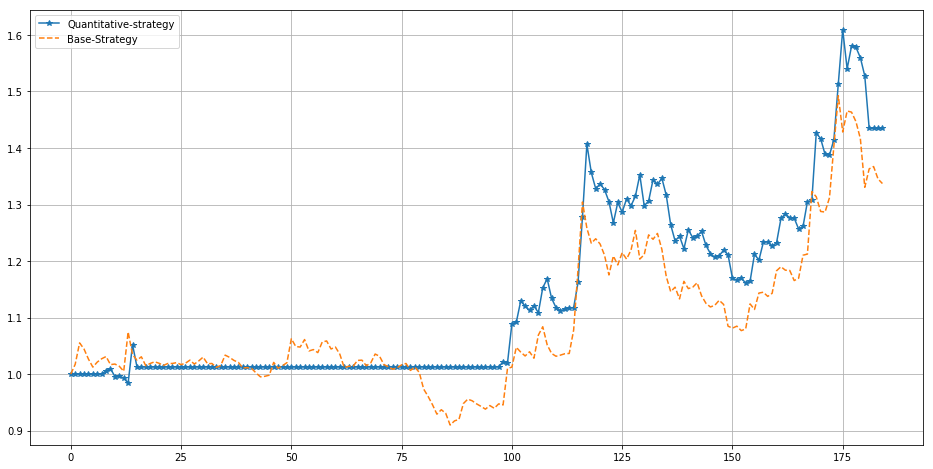

In [128]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.figure(figsize=(16, 8))
plt.plot(quantitative_gain, '-*', label='Quantitative-strategy')  # 量化策略
plt.plot(base_gain.values, '--', label='Base-Strategy')           # 基准策略
plt.legend(loc='upper left')
plt.grid(True)
plt.show()